According to the World Health Organization, pneumonia killed more than 808,000 children under the age of five in 2017. An accurate and timely diagnosis of the disease could be the difference in saving many lives.
we'll take on the role of a Deep Learning Engineer for an R&D company that focuses on developing cutting edge technologies to assist hospitals in diagnosing patients, particularly children.

## Loading the dataset

In [1]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

--2024-07-18 08:43:44--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 54.231.228.49, 3.5.12.48, 3.5.29.101, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|54.231.228.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘xray_dataset.tar.gz’

xray_dataset.tar.gz 100%[===================>]   1.14G  12.4MB/s    in 97s     

2024-07-18 08:45:22 (12.0 MB/s) - ‘xray_dataset.tar.gz’ saved [1223407715/1223407715]



In [2]:
import tarfile

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)

# Use it like this:
extract_tar_gz('/content/xray_dataset.tar.gz', '/content/')

## Creating the train and test and validation sets

In [3]:
import tensorflow as tf
from tensorflow.keras import layers

In [4]:
train_set=tf.keras.utils.image_dataset_from_directory(
    "/content/chest_xray/train",
    labels="inferred",
    label_mode="categorical",
    batch_size=128,
    image_size=(256,256),
    validation_split=0.25,
    subset="training",
    seed=417
)
val_set=tf.keras.utils.image_dataset_from_directory(
    "/content/chest_xray/train",
    labels="inferred",
    label_mode="categorical",
    batch_size=128,
    image_size=(256,256),
    validation_split=0.25,
    subset="validation",
    seed=417
)
test_set=tf.keras.utils.image_dataset_from_directory(
    "/content/chest_xray/test",
    labels="inferred",
    label_mode="categorical",
    batch_size=128,
    image_size=(256,256),
    seed=417
)

Found 5232 files belonging to 2 classes.
Using 3924 files for training.
Found 5232 files belonging to 2 classes.
Using 1308 files for validation.
Found 624 files belonging to 2 classes.


In [5]:
# normalizing the images

train_imgs = train_set.map(lambda imgs, labels: imgs)
normalization_layer = layers.Normalization(axis=-1)
normalization_layer.adapt(train_imgs)

train_set_normalized = train_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))
validation_set_normalized = val_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))
test_set_normalized = test_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

In [6]:
class_names = train_set.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [7]:
%matplotlib inline
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [8]:
train_set_elem=train_set_normalized.take(1)

for images, labels in train_set_elem:
  labels=labels
  images=images
  im=images.numpy()
  break

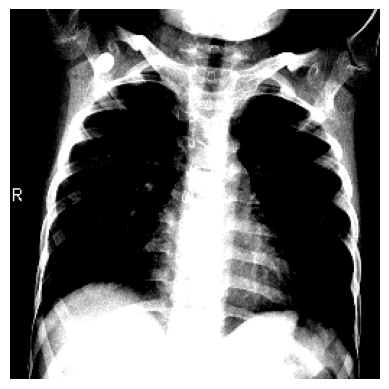

In [9]:
plt.imshow(im[0])
plt.axis('off')
plt.show()

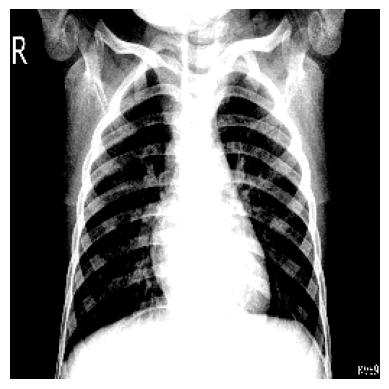

In [10]:
plt.imshow(im[1])
plt.axis('off')
plt.show()

In [11]:
train_set_elem = train_set.take(1)
for images, labels in train_set_elem:
    images = images.numpy()
    labels = labels.numpy()

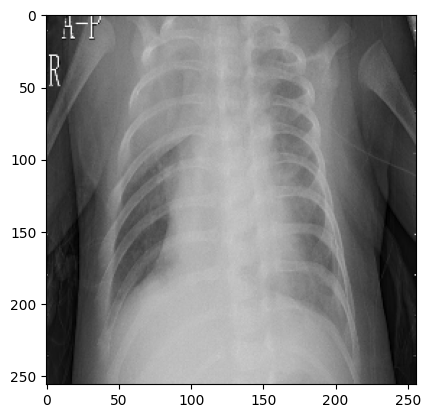

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


In [12]:
idx = 0
plt.imshow(images[idx]/255.0)
plt.show()
print(f"Training Set Image Label: {labels[idx]}")
print(f"Training Set Image Shape: {images[idx].shape}")

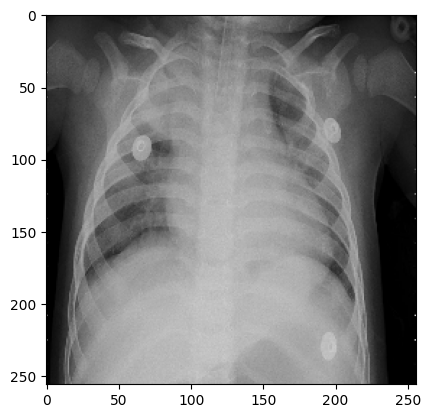

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


In [13]:
idx = 1
plt.imshow(images[idx]/255.0)
plt.show()
print(f"Training Set Image Label: {labels[idx]}")
print(f"Training Set Image Shape: {images[idx].shape}")

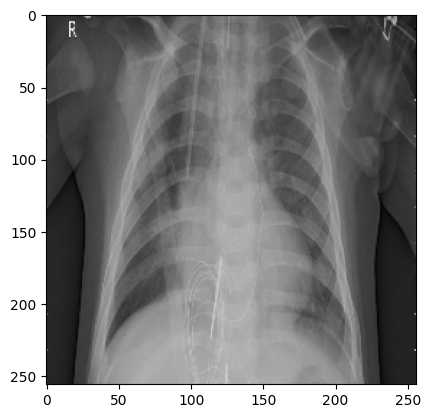

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


In [14]:
idx = 2
plt.imshow(images[idx]/255.0)
plt.show()
print(f"Training Set Image Label: {labels[idx]}")
print(f"Training Set Image Shape: {images[idx].shape}")

The X-rays are not centered. The images are all rotated at different angles. Additionally, even though the images look to be in greyscale, they have 3 channels.

The images don't seem to have a lot of information, but, because of the overlap of ribs and lungs, it could be difficult to extract features specific to the infection. A more complex model could perhaps manage to extract relevant features.

Given the differences between how the X-rays were taken, the images could be rotated, at the very least, as part of data augmentation.

## First Model: Simple CNN I

In [20]:
# rescalling the data for higher acuracy
normalization_layer = layers.Rescaling(1/255)

train_set_normalized = train_set.map(lambda x, y: (normalization_layer(x), y))
validation_set_normalized = val_set.map(lambda x, y: (normalization_layer(x), y))
test_set_normalized = test_set.map(lambda x, y: (normalization_layer(x), y))

In [21]:
cnn_model=tf.keras.Sequential()


In [22]:

# Add the first Conv2D layer with the correct input shape
cnn_model.add(layers.Conv2D(filters=16, kernel_size=3, strides=2, activation='relu', input_shape=(256, 256, 3)))
# Add MaxPooling layer
cnn_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
# Flatten the output before the dense layers
cnn_model.add(layers.Flatten())
# Add Dense layers
cnn_model.add(layers.Dense(16, activation="relu"))
cnn_model.add(layers.Dense(2))

opt=tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cnn_model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 127, 127, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 63504)             0         
                                                                 
 dense_2 (Dense)             (None, 16)                1016080   
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1016562 (3.88 MB)
Trainable params: 1016562 (3.88 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [24]:
cnn_model.fit(train_set_normalized, validation_data=validation_set_normalized, epochs=5)

Epoch 1/5
31/31 [==============================] - 35s 960ms/step - loss: 0.1582 - accuracy: 0.9574 - val_loss: 0.1470 - val_accuracy: 0.9541
Epoch 2/5
31/31 [==============================] - 36s 937ms/step - loss: 0.1266 - accuracy: 0.9704 - val_loss: 0.1303 - val_accuracy: 0.9564
Epoch 3/5
31/31 [==============================] - 36s 983ms/step - loss: 0.1050 - accuracy: 0.9753 - val_loss: 0.1376 - val_accuracy: 0.9534
Epoch 4/5
31/31 [==============================] - 37s 1s/step - loss: 0.1031 - accuracy: 0.9730 - val_loss: 0.1160 - val_accuracy: 0.9618
Epoch 5/5
31/31 [==============================] - 33s 895ms/step - loss: 0.0814 - accuracy: 0.9804 - val_loss: 0.1026 - val_accuracy: 0.9648


Both the validation and training accuracies are quite high even though the model was trained for only 5 epochs. It is possible the model is overfitting. Adding regularization, data augmentation, and more fully-connected layers could help prevent some overfitting while still ensuring good performance.

Observations:
High Accuracy: The high training and validation accuracy indicate that the model is learning effectively and generalizing well to the validation set.

Decreasing Loss: Both training and validation losses are decreasing, which is a good sign that the model is improving over epochs.

No Overfitting: The validation accuracy is close to the training accuracy, and the validation loss is not increasing, which suggests that the model is not overfitting.

Recommendations:
More Epochs: Training for more epochs might further improve the model, but monitor the validation loss and accuracy to ensure it doesn’t overfit.

Data Augmentation: If you haven’t already, consider using data augmentation to make the model more robust to variations in the input data.

Regularization Techniques: Techniques such as dropout or L2 regularization can be added to reduce the risk of overfitting further.

Model Complexity: If you find that the model starts to overfit or if you want to improve accuracy further, consider increasing the complexity of the model (e.g., more layers, more filters).

Validation with Test Set: Ensure to evaluate the final model on a separate test set to confirm its generalization capability.

## First Model: Simple CNN II

In [25]:
# IMG_SIZE = 180

# resize_and_rescale = tf.keras.Sequential([
#   layers.Resizing(IMG_SIZE, IMG_SIZE),
#   layers.Rescaling(1./255)
# ])
# result = resize_and_rescale(image)
# _ = plt.imshow(result)

In [26]:
first_model=tf.keras.Sequential()

In [27]:
# Regularlization and data augumantation


# Add the first Conv2D layer with the correct input shape
first_model.add(layers.RandomZoom(height_factor=0.1))
first_model.add(layers.RandomRotation(factor=0.2))
first_model.add(layers.Conv2D(filters=16, kernel_size=3, strides=2, activation='relu', input_shape=(256, 256, 3)))
# Add MaxPooling layer
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
# Flatten the output before the dense layers
first_model.add(layers.Flatten())
# Add Dense layers
first_model.add(layers.Dense(16, activation="relu"))
first_model.add(layers.Dense(2))

call = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

opt=tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
first_model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
first_model.build((None, 256,256, 3))

first_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 127, 127, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 63504)             0         
                                                                 
 dense_4 (Dense)             (None, 16)               

In [28]:
first_model.fit(train_set_normalized, epochs=15, validation_data=validation_set_normalized, callbacks=[call])

Epoch 1/15
31/31 [==============================] - 36s 908ms/step - loss: 1.6731 - accuracy: 0.7319 - val_loss: 0.5700 - val_accuracy: 0.7492
Epoch 2/15
31/31 [==============================] - 35s 916ms/step - loss: 0.5952 - accuracy: 0.7398 - val_loss: 0.5815 - val_accuracy: 0.7492
Epoch 3/15
31/31 [==============================] - 37s 1s/step - loss: 0.5274 - accuracy: 0.7398 - val_loss: 0.4249 - val_accuracy: 0.7492
Epoch 4/15
31/31 [==============================] - 33s 900ms/step - loss: 0.4651 - accuracy: 0.7398 - val_loss: 0.4162 - val_accuracy: 0.7492
Epoch 5/15
31/31 [==============================] - 36s 945ms/step - loss: 0.3783 - accuracy: 0.7398 - val_loss: 0.3189 - val_accuracy: 0.7492
Epoch 6/15
31/31 [==============================] - 35s 934ms/step - loss: 0.3349 - accuracy: 0.8423 - val_loss: 0.2818 - val_accuracy: 0.9075
Epoch 7/15
31/31 [==============================] - 37s 994ms/step - loss: 0.3147 - accuracy: 0.8764 - val_loss: 0.3179 - val_accuracy: 0.8677
Ep

Our model performs fairly better without overfitting

## Second Model: Transfer Learning


In [32]:
base_model=tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(256,256,3),

)
base_model.trainable=False

In [33]:
input_layer=tf.keras.Input(shape=(256,256,3))
pre_input=tf.keras.applications.resnet50.preprocess_input(input_layer)
features_layer=base_model(pre_input,training=False)
pooling_l=layers.GlobalAveragePooling2D()(features_layer)
output=layers.Dense(2)(pooling_l)
T_model=tf.keras.Model(inputs=input_layer,outputs=output)

T_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 256, 256, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 256, 256, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [34]:
opt=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
T_model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])

In [36]:
call=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
T_model.fit(train_set,validation_data=val_set,epochs=10,callbacks=[call])

Epoch 1/10
31/31 [==============================] - 64s 1s/step - loss: 1.1282 - accuracy: 0.8721 - val_loss: 0.3201 - val_accuracy: 0.9365
Epoch 2/10
31/31 [==============================] - 43s 1s/step - loss: 0.1929 - accuracy: 0.9618 - val_loss: 0.1737 - val_accuracy: 0.9534
Epoch 3/10
31/31 [==============================] - 44s 1s/step - loss: 0.1218 - accuracy: 0.9674 - val_loss: 0.1164 - val_accuracy: 0.9641
Epoch 4/10
31/31 [==============================] - 44s 1s/step - loss: 0.0820 - accuracy: 0.9743 - val_loss: 0.0822 - val_accuracy: 0.9717
Epoch 5/10
31/31 [==============================] - 43s 1s/step - loss: 0.0614 - accuracy: 0.9778 - val_loss: 0.0817 - val_accuracy: 0.9702
Epoch 6/10
31/31 [==============================] - 51s 1s/step - loss: 0.0535 - accuracy: 0.9799 - val_loss: 0.0654 - val_accuracy: 0.9755
Epoch 7/10
31/31 [==============================] - 51s 1s/step - loss: 0.0462 - accuracy: 0.9829 - val_loss: 0.0811 - val_accuracy: 0.9717
Epoch 8/10
31/31 [==

In [38]:
T_model.evaluate(test_set)

5/5 [==============================] - 5s 502ms/step - loss: 1.0000 - accuracy: 0.7821


[0.9999615550041199, 0.7820512652397156]

In [39]:
first_model.evaluate(test_set_normalized)

5/5 [==============================] - 4s 123ms/step - loss: 0.5766 - accuracy: 0.8093


[0.5766082406044006, 0.8092948794364929]

In [40]:
cnn_model.evaluate(test_set_normalized)

5/5 [==============================] - 3s 77ms/step - loss: 1.2014 - accuracy: 0.7500


[1.2014342546463013, 0.75]